# Car Price prediction

<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам
*Этот ноутбук является шаблоном (Baseline) к текущему соревнованию и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.


> **Baseline** создается больше как шаблон, где можно посмотреть, как происходит обращение с входящими данными и что нужно получить на выходе. При этом ML начинка может быть достаточно простой. Это помогает быстрее приступить к самому ML, а не тратить ценное время на инженерные задачи. 
Также baseline является хорошей опорной точкой по метрике. Если наше решение хуже baseline -  мы явно делаем что-то не так и стоит попробовать другой путь) 

## В baseline мы сделаем следующее:
* Построим "наивную"/baseline модель, предсказывающую цену по модели и году выпуска (с ней будем сравнивать другие модели)
* Обработаем и отнормируем признаки
* Сделаем первую модель на основе градиентного бустинга с помощью CatBoost
* Сделаем вторую модель на основе нейронных сетей и сравним результаты
* Сделаем multi-input нейронную сеть для анализа табличных данных и текста одновременно
* Добавим в multi-input сеть обработку изображений
* Осуществим ансамблирование градиентного бустинга и нейронной сети (усреднение их предсказаний)

In [1]:
from google.colab import drive
drive.mount('/content/drive') 


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -q tensorflow==2.3

In [3]:
#аугментации изображений
!pip install albumentations -q

In [4]:
!pip install catboost

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations

# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline
#print(os.listdir("/content/drive/My Drive/cars2/"))
DATA_PATH ="/content/drive/My Drive/cars2/"
PATH = "/content/" # рабочая директория
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.6.9 (default, Oct  8 2020, 12:12:24) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0


In [7]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [8]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [9]:
!pip freeze > requirements.txt

# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [88]:
DATA_DIR ="/content/drive/My Drive/cars2/"
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [11]:
train.head()

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
0,седан,BMW,чёрный,Авто на бодром ходу. Все работает отлично. П...,3.0 LTR,272 N12,бензин,245000,2007,5ER,530xi 3.0 AT (272 л.с.) 4WD,4,599000.0,2007,1099980990,SEDAN AUTOMATIC 3.0,автоматическая,3 или более,NaN,Оригинал,полный,Левый
1,седан,AUDI,серебристый,"Продажа от собственника, второй владелец, ПТС ...",2.8 LTR,204 N12,бензин,183000,2011,A6,2.8 CVT (204 л.с.),4,850000.0,2011,1095836906,SEDAN VARIATOR 2.8,вариатор,2 владельца,8 лет и 6 месяцев,Оригинал,передний,Левый
2,седан,MERCEDES,чёрный,Внимание! Только для клиентов AVILON Автомобил...,3.5 LTR,306 N12,бензин,122733,2009,E_KLASSE,350 3.5 AT (306 л.с.) 4WD,4,1325000.0,2013,1100195530,SEDAN AUTOMATIC 3.5,автоматическая,3 или более,NaN,Оригинал,полный,Левый
3,седан,AUDI,белый,В комплекте зимние колёса. 27.07.2020 Замена п...,2.0 LTR,180 N12,бензин,151000,2011,A6,2.0 CVT (180 л.с.),4,815000.0,2011,1099880662,SEDAN VARIATOR 2.0,вариатор,3 или более,4 года и 9 месяцев,Оригинал,передний,Левый
4,лифтбек,AUDI,белый,"Отличный авто, 2011 года выпуска, кроме передн...",1.8 LTR,160 N12,бензин,140000,2007,A5,1.8 CVT (160 л.с.),5,810000.0,2011,1083244610,LIFTBACK VARIATOR 1.8,вариатор,3 или более,2 года и 9 месяцев,Оригинал,передний,Левый


In [12]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

In [13]:
train.head()

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
0,седан,BMW,чёрный,Авто на бодром ходу. Все работает отлично. П...,3.0 LTR,272 N12,бензин,245000,2007,5ER,530xi 3.0 AT (272 л.с.) 4WD,4,599000.0,2007,1099980990,SEDAN AUTOMATIC 3.0,автоматическая,3 или более,NaN,Оригинал,полный,Левый
1,седан,AUDI,серебристый,"Продажа от собственника, второй владелец, ПТС ...",2.8 LTR,204 N12,бензин,183000,2011,A6,2.8 CVT (204 л.с.),4,850000.0,2011,1095836906,SEDAN VARIATOR 2.8,вариатор,2 владельца,8 лет и 6 месяцев,Оригинал,передний,Левый
2,седан,MERCEDES,чёрный,Внимание! Только для клиентов AVILON Автомобил...,3.5 LTR,306 N12,бензин,122733,2009,E_KLASSE,350 3.5 AT (306 л.с.) 4WD,4,1325000.0,2013,1100195530,SEDAN AUTOMATIC 3.5,автоматическая,3 или более,NaN,Оригинал,полный,Левый
3,седан,AUDI,белый,В комплекте зимние колёса. 27.07.2020 Замена п...,2.0 LTR,180 N12,бензин,151000,2011,A6,2.0 CVT (180 л.с.),4,815000.0,2011,1099880662,SEDAN VARIATOR 2.0,вариатор,3 или более,4 года и 9 месяцев,Оригинал,передний,Левый
4,лифтбек,AUDI,белый,"Отличный авто, 2011 года выпуска, кроме передн...",1.8 LTR,160 N12,бензин,140000,2007,A5,1.8 CVT (160 л.с.),5,810000.0,2011,1083244610,LIFTBACK VARIATOR 1.8,вариатор,3 или более,2 года и 9 месяцев,Оригинал,передний,Левый


In [14]:
test.head()

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
0,универсал 5 дв.,MERCEDES,чёрный,Всем привет!\n\nПродам эксклюзивный проект 124...,3.0 LTR,220 N12,бензин,350000,1984,W124,300 3.0 AT (220 л.с.),5,1991,1099427284,WAGON_5_DOORS AUTOMATIC 3.0,автоматическая,3 или более,6 лет и 3 месяца,Оригинал,задний,Левый
1,купе,BMW,белый,Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...,3.0 LTR,313 N12,дизель,15000,2011,6ER,640d xDrive 3.0d AT (313 л.с.) 4WD,2,2013,1096405886,COUPE AUTOMATIC 3.0,автоматическая,1 владелец,6 лет и 6 месяцев,Оригинал,полный,Левый
2,купе,BMW,пурпурный,"Машина тут продаётся не в первый раз, НО! Толь...",2.5 LTR,218 N12,бензин,166600,2005,3ER,325xi 2.5 AT (218 л.с.) 4WD,2,2008,1100195294,COUPE AUTOMATIC 2.5,автоматическая,3 или более,NaN,Оригинал,полный,Левый
3,седан,BMW,белый,"Автомобиль в отличном состоянии, весь в родной...",2.0 LTR,136 N12,бензин,147000,2005,3ER,318i 2.0 AT (136 л.с.),4,2007,1099827282,SEDAN AUTOMATIC 2.0,автоматическая,2 владельца,NaN,Оригинал,задний,Левый
4,седан,BMW,чёрный,Немка! с бесключивым доступом и камерой заднег...,2.0 LTR,190 N12,дизель,24000,2016,5ER,520d xDrive 2.0d AT (190 л.с.) 4WD,4,2019,1100076198,SEDAN AUTOMATIC 2.0,автоматическая,1 владелец,NaN,Оригинал,полный,Левый


# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [15]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.10, shuffle=True, random_state=RANDOM_SEED)

In [16]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.25%


In [17]:
predicts.head()

,0
0,685000.0
1,910000.0
2,1299000.0
3,570000.0
4,1270000.0


# EDA

Проведем быстрый анализ данных для того, чтобы понимать, сможет ли с этими данными работать наш алгоритм.

# PreProc Tabular Data

In [18]:
 #удалим дубликаты: 
 train.drop_duplicates()


,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
0,седан,BMW,чёрный,Авто на бодром ходу. Все работает отлично. П...,3.0 LTR,272 N12,бензин,245000,2007,5ER,530xi 3.0 AT (272 л.с.) 4WD,4,599000.0,2007,1099980990,SEDAN AUTOMATIC 3.0,автоматическая,3 или более,NaN,Оригинал,полный,Левый
1,седан,AUDI,серебристый,"Продажа от собственника, второй владелец, ПТС ...",2.8 LTR,204 N12,бензин,183000,2011,A6,2.8 CVT (204 л.с.),4,850000.0,2011,1095836906,SEDAN VARIATOR 2.8,вариатор,2 владельца,8 лет и 6 месяцев,Оригинал,передний,Левый
2,седан,MERCEDES,чёрный,Внимание! Только для клиентов AVILON Автомобил...,3.5 LTR,306 N12,бензин,122733,2009,E_KLASSE,350 3.5 AT (306 л.с.) 4WD,4,1325000.0,2013,1100195530,SEDAN AUTOMATIC 3.5,автоматическая,3 или более,NaN,Оригинал,полный,Левый
3,седан,AUDI,белый,В комплекте зимние колёса. 27.07.2020 Замена п...,2.0 LTR,180 N12,бензин,151000,2011,A6,2.0 CVT (180 л.с.),4,815000.0,2011,1099880662,SEDAN VARIATOR 2.0,вариатор,3 или более,4 года и 9 месяцев,Оригинал,передний,Левый
4,лифтбек,AUDI,белый,"Отличный авто, 2011 года выпуска, кроме передн...",1.8 LTR,160 N12,бензин,140000,2007,A5,1.8 CVT (160 л.с.),5,810000.0,2011,1083244610,LIFTBACK VARIATOR 1.8,вариатор,3 или более,2 года и 9 месяцев,Оригинал,передний,Левый
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6677,седан,BMW,серый,Продаётся любимый автомобиль! За годы эксплуат...,2.0 LTR,150 N12,бензин,232777,2005,3ER,320i 2.0 AT (150 л.с.),4,550000.0,2006,1100036650,SEDAN AUTOMATIC 2.0,автоматическая,3 или более,NaN,Оригинал,задний,Левый
6678,седан,BMW,чёрный,Куплена у официального дилера в 2017 г. \n\nТр...,2.0 LTR,190 N12,дизель,33700,2013,5ER,520d 2.0d AT (190 л.с.),4,1900000.0,2016,1090506038,SEDAN AUTOMATIC 2.0,автоматическая,3 или более,2 года и 2 месяца,Оригинал,задний,Левый
6679,седан,BMW,белый,Торг на месте. Все работает. Сборка немецкая. ...,2.0 LTR,143 N12,бензин,200000,2008,3ER,318i 2.0 AT (143 л.с.),4,530000.0,2008,1095155628,SEDAN AUTOMATIC 2.0,автоматическая,3 или более,2 года и 2 месяца,Оригинал,задний,Левый
6680,седан,AUDI,чёрный,Автомобиль в отличном состоянии.\n3-из Авто в ...,3.0 LTR,310 N12,бензин,72000,2013,A8,Long 3.0 AT (310 л.с.) 4WD,4,1970000.0,2016,1099625256,SEDAN AUTOMATIC 3.0,автоматическая,3 или более,NaN,Оригинал,полный,Левый


In [89]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


In [20]:
data.nunique()

bodyType                  17
brand                      3
color                     16
description             7654
engineDisplacement        48
enginePower              154
fuelType                   4
mileage                 3507
modelDate                 43
model_info               122
name                     976
numberOfDoors              4
productionDate            39
sell_id                 8353
vehicleConfiguration     312
vehicleTransmission        4
Владельцы                  3
Владение                 180
ПТС                        2
Привод                     3
Руль                       2
sample                     2
price                   1629
dtype: int64

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              8353 non-null   object 
 1   brand                 8353 non-null   object 
 2   color                 8353 non-null   object 
 3   description           8353 non-null   object 
 4   engineDisplacement    8353 non-null   object 
 5   enginePower           8353 non-null   object 
 6   fuelType              8353 non-null   object 
 7   mileage               8353 non-null   int64  
 8   modelDate             8353 non-null   int64  
 9   model_info            8353 non-null   object 
 10  name                  8353 non-null   object 
 11  numberOfDoors         8353 non-null   int64  
 12  productionDate        8353 non-null   int64  
 13  sell_id               8353 non-null   int64  
 14  vehicleConfiguration  8353 non-null   object 
 15  vehicleTransmission  

In [22]:
# engineDisplacement преобразуем в числовой признак:

def engineDisplacement(row):
    row = str(row)
    engine = re.findall('\d\.\d', row)
    if engine == []:
        return None
    return float(engine[0])
   
data['engineDisplacement'] = data['engineDisplacement'].apply(engineDisplacement)
data['engineDisplacement'].fillna(data['engineDisplacement'].median(),inplace=True)
data.engineDisplacement = data.engineDisplacement .apply(lambda x: float(x))
#data['engineDisplacement']= np.log(data['engineDisplacement']) # - хуже результат


In [23]:
data['engineDisplacement'].unique()

array([3. , 2.5, 2. , 3.5, 1.8, 2.2, 5.5, 4.8, 1.6, 4.7, 4. , 1.5, 2.4,
       1.4, 2.1, 5.2, 4.4, 2.8, 4.2, 3.2, 6. , 3.7, 5. , 1.2, 3.6, 2.3,
       6.2, 1.7, 1.3, 5.4, 3.1, 2.6, 3.8, 4.1, 2.9, 6.6, 5.9, 2.7, 0.7,
       1.9, 4.3, 5.8, 4.9, 3.4, 6.3, 5.6, 4.6])

In [24]:
data.loc[data.engineDisplacement=='undefined', 'engineDisplacement'] = '2.0'
data.loc[data.engineDisplacement=='0.7', 'engineDisplacement'] = '1.0'

In [25]:
# вариант 1: просто  удалим  признак  "Владение"
#data = data.drop('Владение', axis = 1)

# вариант 2:выделим пропуски  признака  "Владение" в отдельную категорию
#data.Владение.fillna('X', inplace=True)

# вариант 3: Преобразуем срок владения в (месяцы) числовое значение и заполним пропуски
def num_of_months(row):
    if pd.notnull(row):
        list_ownership = row.split()
        if len(list_ownership) == 2:
            if list_ownership[1] in ['год', 'года', 'лет']:
                return int(list_ownership[0])*12
            return int(list_ownership[0])
        return int(list_ownership[0])*12 + int(list_ownership[3])

data['Владение'] = data['Владение'].apply(num_of_months)
data['Владение'].fillna(data['Владение'].median(),inplace=True)
data['Владение'] = data['Владение'].astype(float)
#data['Владение']= np.log(data['Владение']) # для нейросети


In [26]:
# наводим порядок с пропуском в "Владельцы" заполняем самым частым значением:
data['Владельцы'] = data[['Владельцы']].fillna(data['Владельцы'].value_counts().index[0])
# Владельцы, оставим только цифру
data['Владельцы'] = data['Владельцы'].apply(lambda x: str(x.split()[0]))


In [27]:
 # vehicleConfiguration, выведем только трансмиссию
data['vehicleConfiguration'] = data['vehicleConfiguration'].apply(lambda x: x.split()[1])


In [28]:
data['vehicleConfiguration']

0       AUTOMATIC
1       AUTOMATIC
2       AUTOMATIC
3       AUTOMATIC
4       AUTOMATIC
          ...    
8348    AUTOMATIC
8349    AUTOMATIC
8350    AUTOMATIC
8351    AUTOMATIC
8352    AUTOMATIC
Name: vehicleConfiguration, Length: 8353, dtype: object

In [29]:
# enginePower, оставим только цифру в enginePower
data['enginePower'] = data['enginePower'].apply(lambda x: float(x.split()[0]))

In [30]:
data['tax'] = data.enginePower.apply(lambda x: x*12 if x<=100 
                                           else x*25 if x>100 and x<=125
                                           else x*35 if x>125 and x<=150
                                           else x*45 if x>150 and x<=175
                                           else x*55 if x>175 and x<=200
                                           else x*65 if x>200 and x<=225
                                           else x*75 if x>225 and x<=250
                                           else x*150)

In [68]:
# деление на 8 категорий дает лучший результат, чем на 5 (как по НК РФ)
data['tax_cat'] = data.enginePower.apply(lambda x: 1 if x<=100  
                                           else 2 if x>100 and x<=125
                                           else 3 if x>125 and x<=150
                                           else 4 if x>150 and x<=175
                                           else 5 if x>175 and x<=200
                                           else 6 if x>200 and x<=225
                                           else 7 if x>225 and x<=250
                                           else 8)

In [32]:
data['tax_cat'] = data['tax_cat'].astype(str)
data['tax_cat']

0       4
1       5
2       4
3       2
4       3
       ..
8348    2
8349    3
8350    2
8351    5
8352    5
Name: tax_cat, Length: 8353, dtype: object

In [33]:
data['productionDate'] = 2021- data['productionDate']
data['productionDate']  = data['productionDate'] .astype(float)

In [34]:
data['modelDate'] = 2021- data['modelDate']
data['modelDate'] =data['modelDate'].astype(float)

In [35]:
# Пока мы не преобразовали признаки age и mileage, создадим ещё один признак - mileagePerYear, который покажет, насколько интенсивно использовали автомобиль.

In [36]:
data['mileage'] =data['mileage'].astype(float)

In [67]:
data['mileagePerYear'] = (data['mileage'] / data['productionDate'])
data['mileagePerYear'] = data['mileagePerYear'].round()
data['mileagePerYear'].unique()
def cat_mileagePerYear(x):
    if x < 10000: x = 1
    elif 10000 <= x < 20000: x = 2
    elif 20000 <= x < 30000: x = 3
    elif 30000 <= x: x = 4
    return x  
data['mileagePerYear'] = data['mileagePerYear'].apply(lambda x: cat_mileagePerYear(x))
data['mileagePerYear'] = data['mileagePerYear'].astype(str)
data['mileagePerYear']

0       2
1       1
2       2
3       2
4       2
       ..
8348    2
8349    1
8350    2
8351    2
8352    1
Name: mileagePerYear, Length: 8353, dtype: object

In [38]:
data['numberOfDoors'] = data['numberOfDoors'].apply(lambda s: str(int(s)))

In [101]:
data['name'] = data['name'].str.split().apply(lambda s: s[0])

In [102]:
data['name'].nunique()

236

In [40]:
#data['price'] = data['price'].astype(int)

In [41]:
data.bodyType = data.bodyType.str.split().apply(lambda s: s[0])
data.bodyType.unique()

array(['универсал', 'купе', 'седан', 'внедорожник', 'родстер', 'лифтбек',
       'хэтчбек', 'купе-хардтоп', 'минивэн', 'кабриолет', 'пикап',
       'компактвэн', 'лимузин'], dtype=object)

In [42]:
data['model_info'].value_counts()


5ER               776
3ER               578
X5                501
E_KLASSE          490
A6                433
                 ... 
X3_M                1
W201                1
COUPE               1
Z3M                 1
SLC_KLASSE_AMG      1
Name: model_info, Length: 122, dtype: int64

In [43]:
data.head()

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,sample,price,tax,tax_cat,mileagePerYear
0,универсал,MERCEDES,чёрный,Всем привет!\n\nПродам эксклюзивный проект 124...,3,220.0,бензин,350000.0,37.0,W124,300,5,30.0,1099427284,AUTOMATIC,автоматическая,3,75.0,Оригинал,задний,Левый,0,0.0,14300.0,4,2
1,купе,BMW,белый,Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...,3,313.0,дизель,15000.0,10.0,6ER,640d,2,8.0,1096405886,AUTOMATIC,автоматическая,1,78.0,Оригинал,полный,Левый,0,0.0,46950.0,5,1
2,купе,BMW,пурпурный,"Машина тут продаётся не в первый раз, НО! Толь...",2.5,218.0,бензин,166600.0,16.0,3ER,325xi,2,13.0,1100195294,AUTOMATIC,автоматическая,3,38.0,Оригинал,полный,Левый,0,0.0,14170.0,4,2
3,седан,BMW,белый,"Автомобиль в отличном состоянии, весь в родной...",2,136.0,бензин,147000.0,16.0,3ER,318i,4,14.0,1099827282,AUTOMATIC,автоматическая,2,38.0,Оригинал,задний,Левый,0,0.0,4760.0,2,2
4,седан,BMW,чёрный,Немка! с бесключивым доступом и камерой заднег...,2,190.0,дизель,24000.0,5.0,5ER,520d,4,2.0,1100076198,AUTOMATIC,автоматическая,1,38.0,Оригинал,полный,Левый,0,0.0,10450.0,3,2


In [44]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              8353 non-null   object 
 1   brand                 8353 non-null   object 
 2   color                 8353 non-null   object 
 3   description           8353 non-null   object 
 4   engineDisplacement    8353 non-null   object 
 5   enginePower           8353 non-null   float64
 6   fuelType              8353 non-null   object 
 7   mileage               8353 non-null   float64
 8   modelDate             8353 non-null   float64
 9   model_info            8353 non-null   object 
 10  name                  8353 non-null   object 
 11  numberOfDoors         8353 non-null   object 
 12  productionDate        8353 non-null   float64
 13  sell_id               8353 non-null   int64  
 14  vehicleConfiguration  8353 non-null   object 
 15  vehicleTransmission  

Посмотрим, как выглядят распределения числовых признаков:

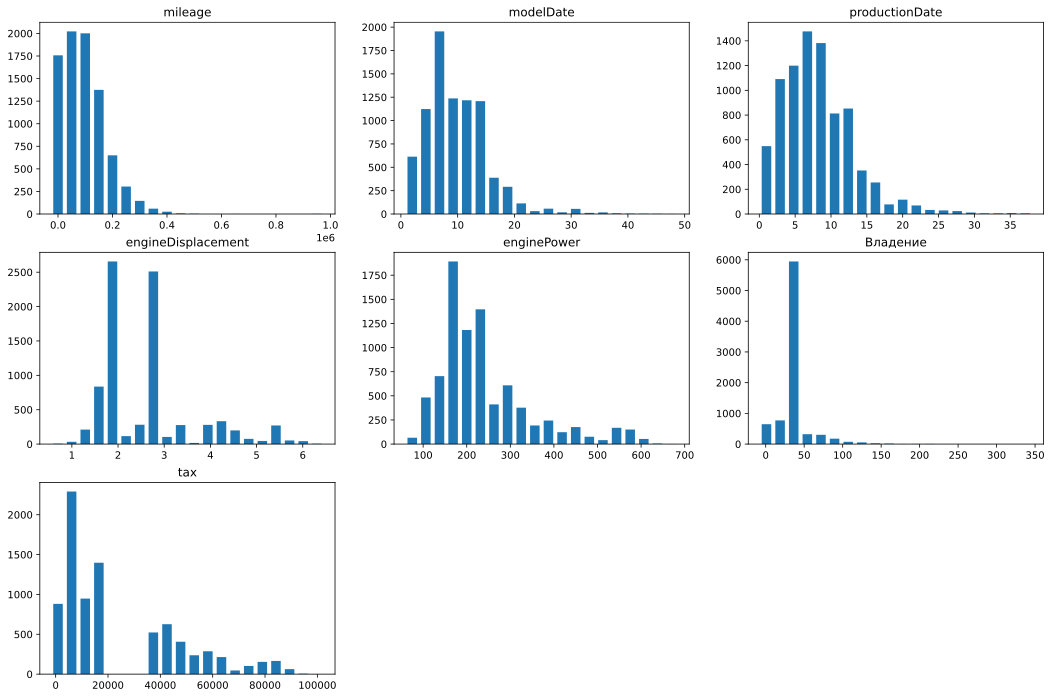

In [45]:
#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

visualize_distributions({
   'mileage': data['mileage'].dropna(),
   'modelDate': data['modelDate'].dropna(),
    'productionDate': data['productionDate'].dropna(),
    'engineDisplacement': data['engineDisplacement'].dropna(),
   'enginePower': data['enginePower'].dropna(),
   'Владение': data['Владение'].dropna(),
    'enginePower': data['enginePower'].dropna(),
      'tax': data['tax'].dropna()

})

Итого:
* CatBoost сможет работать с признаками и в таком виде, но для нейросети нужны нормированные данные.

In [46]:
#data['Владение']= np.log(data['Владение']) # для нейросети
#data['mileage']= np.log(data['mileage']) # для нейросети
#data['modelDate']= np.log(data['modelDate']) # для нейросети
#data['productionDate']= np.log(data['productionDate']) # для нейросети

In [47]:
#data['Владельцы']= data['Владельцы'].astype(str)

In [48]:
data.head()

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,sample,price,tax,tax_cat,mileagePerYear
0,универсал,MERCEDES,чёрный,Всем привет!\n\nПродам эксклюзивный проект 124...,3,220.0,бензин,350000.0,37.0,W124,300,5,30.0,1099427284,AUTOMATIC,автоматическая,3,75.0,Оригинал,задний,Левый,0,0.0,14300.0,4,2
1,купе,BMW,белый,Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...,3,313.0,дизель,15000.0,10.0,6ER,640d,2,8.0,1096405886,AUTOMATIC,автоматическая,1,78.0,Оригинал,полный,Левый,0,0.0,46950.0,5,1
2,купе,BMW,пурпурный,"Машина тут продаётся не в первый раз, НО! Толь...",2.5,218.0,бензин,166600.0,16.0,3ER,325xi,2,13.0,1100195294,AUTOMATIC,автоматическая,3,38.0,Оригинал,полный,Левый,0,0.0,14170.0,4,2
3,седан,BMW,белый,"Автомобиль в отличном состоянии, весь в родной...",2,136.0,бензин,147000.0,16.0,3ER,318i,4,14.0,1099827282,AUTOMATIC,автоматическая,2,38.0,Оригинал,задний,Левый,0,0.0,4760.0,2,2
4,седан,BMW,чёрный,Немка! с бесключивым доступом и камерой заднег...,2,190.0,дизель,24000.0,5.0,5ER,520d,4,2.0,1100076198,AUTOMATIC,автоматическая,1,38.0,Оригинал,полный,Левый,0,0.0,10450.0,3,2


In [69]:
#используем все текстовые признаки как категориальные без предобработки
categorical_features = ['bodyType', 'brand', 'color',  'fuelType', 'model_info', 'name',
 'vehicleTransmission',  'ПТС', 'Привод', 'Руль','mileagePerYear','numberOfDoors','Владельцы','tax_cat']

#используем все числовые признаки
numerical_features = ['mileage', 'modelDate', 'productionDate', 'engineDisplacement','enginePower','tax',
                      'Владение','mileagePerYear'
                      ]



In [70]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки

   
  
                           
    df_output.drop(['description','sell_id','vehicleConfiguration'], axis = 1, inplace=True)
    # ################### Numerical Features ############################################################## 
    # Далее заполняем пропуски
    for column in numerical_features:
        df_output[column].fillna(df_output[column].median(), inplace=True)
    # тут ваш код по обработке NAN
 
    # Нормализация данных и логорифмирование
    scaler = MinMaxScaler()
    for column in numerical_features:
       # df_output[column] = np.log(df_output[column])
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]    
    
    
    # ################### Categorical Features ############################################################## 
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)
    # тут ваш код не Encoding фитчей
    # ....
    
    
    # ################### Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # ....
    
    
    # ################### Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    #df_output.drop(['vehicleConfiguration'], axis = 1, inplace=True)
    
    return df_output

In [71]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(10)

,engineDisplacement,enginePower,mileage,modelDate,productionDate,Владение,sample,price,tax,bodyType_0,bodyType_1,bodyType_2,bodyType_3,bodyType_4,bodyType_5,bodyType_6,bodyType_7,bodyType_8,bodyType_9,bodyType_10,bodyType_11,bodyType_12,brand_0,brand_1,brand_2,color_0,color_1,color_2,color_3,color_4,color_5,color_6,color_7,color_8,color_9,color_10,color_11,color_12,color_13,color_14,...,name_226,name_227,name_228,name_229,name_230,name_231,name_232,name_233,name_234,name_235,vehicleTransmission_0,vehicleTransmission_1,vehicleTransmission_2,vehicleTransmission_3,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2,Руль_0,Руль_1,mileagePerYear_0,mileagePerYear_1,mileagePerYear_2,mileagePerYear_3,numberOfDoors_0,numberOfDoors_1,numberOfDoors_2,numberOfDoors_3,Владельцы_0,Владельцы_1,Владельцы_2,tax_cat_0,tax_cat_1,tax_cat_2,tax_cat_3,tax_cat_4,tax_cat_5,tax_cat_6,tax_cat_7
423,0.220339,0.1200,0.078999,0.208333,0.210526,0.132768,0,0.0,0.041787,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0
1079,0.186441,0.1360,0.176999,0.250000,0.263158,0.104520,0,0.0,0.060519,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0
4964,0.101695,0.1200,0.025244,0.020833,0.026316,0.028249,1,1945000.0,0.041787,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0
1509,0.389831,0.3152,0.199999,0.250000,0.342105,0.104520,0,0.0,0.383285,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
7186,0.389831,0.2784,0.163132,0.125000,0.157895,0.104520,1,2504855.0,0.170749,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0
2891,0.389831,0.3696,0.179999,0.208333,0.236842,0.296610,1,1200000.0,0.432277,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1
4215,0.220339,0.2784,0.031522,0.083333,0.052632,0.104520,1,3329000.0,0.170749,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0
1382,0.220339,0.1088,0.261999,0.375000,0.473684,0.265537,0,0.0,0.039433,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0
3995,0.220339,0.1744,0.139999,0.062500,0.105263,0.104520,1,1750000.0,0.088569,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0
4689,0.559322,0.6304,0.017318,0.041667,0.026316,0.104520,1,10745000.0,0.667147,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1


In [62]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Columns: 430 entries, engineDisplacement to tax_cat_4
dtypes: float64(8), int64(1), uint8(421)
memory usage: 3.9 MB


## Split data

In [72]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)
#train_data['price'] = np.log (train_data['price'])
y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [73]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 0 to 1670
Columns: 432 entries, engineDisplacement to tax_cat_7
dtypes: float64(8), uint8(424)
memory usage: 809.4 KB


In [55]:
# логарифмируем Price:
# model.fit(X, normalize_price(y))
#y = np.log(y)
# обратное логарифмирование:
# predictions = to_orig_price(model.predict(X_test))
#predictions = np.exp (model.predict(X_test))

In [64]:
train_data['price']

1671     599000.0
1672     850000.0
1673    1325000.0
1674     815000.0
1675     810000.0
          ...    
8348     550000.0
8349    1900000.0
8350     530000.0
8351    1970000.0
8352    3000000.0
Name: price, Length: 6682, dtype: float64

# Model 2: CatBoostRegressor

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)

In [119]:
model = CatBoostRegressor(iterations = 15000,
                          #depth=12,
                          #learning_rate = 0.02,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=1000,
                          #task_type='GPU',
                         )
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         #plot=True
         )

Learning rate set to 0.011705
0:	learn: 0.9902636	test: 1.0238712	best: 1.0238712 (0)	total: 4.26ms	remaining: 1m 3s
100:	learn: 0.4607745	test: 0.4677513	best: 0.4677513 (100)	total: 375ms	remaining: 55.3s
200:	learn: 0.3065739	test: 0.3063510	best: 0.3063510 (200)	total: 743ms	remaining: 54.7s
300:	learn: 0.2662614	test: 0.2642703	best: 0.2642703 (300)	total: 1.08s	remaining: 52.8s
400:	learn: 0.2400666	test: 0.2375346	best: 0.2375346 (400)	total: 1.44s	remaining: 52.4s
500:	learn: 0.2167213	test: 0.2132023	best: 0.2132023 (500)	total: 1.78s	remaining: 51.7s
600:	learn: 0.2000185	test: 0.1971468	best: 0.1971468 (600)	total: 2.13s	remaining: 50.9s
700:	learn: 0.1893495	test: 0.1872618	best: 0.1872618 (700)	total: 2.47s	remaining: 50.3s
800:	learn: 0.1832369	test: 0.1816559	best: 0.1816540 (799)	total: 2.81s	remaining: 49.9s
900:	learn: 0.1789154	test: 0.1775382	best: 0.1775382 (900)	total: 3.16s	remaining: 49.5s
1000:	learn: 0.1751231	test: 0.1741702	best: 0.1741702 (1000)	total: 3.51

In [120]:
test_predict_catboost = model.predict(X_test)
#test_predict_catboost = np.exp(model.predict(X_test))
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

TEST mape: 12.47%


### Submission

In [122]:
sub_predict_catboost = model.predict(X_sub)
#sub_predict_catboost = np. exp (model.predict(X_sub)) # добавили антилогарифм!!!!!
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv(DATA_PATH +'catboost_submission2.csv', index=False)

In [ ]:
sample_submission['price']

# Model 3: Tabular NN

Построим обычную сеть:

## Simple Dense NN

In [123]:

model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu")) #512 best 
model.add(L.Dropout(0.9)) #0.8 best
model.add(L.Dense(300, activation="relu")) #300 -best
model.add(L.Dropout(0.6)) #0.6 best
model.add(L.Dense(1, activation="linear"))

In [124]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               221184    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               153900    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 301       
Total params: 375,385
Trainable params: 375,385
Non-trainable params: 0
_________________________________________________________________


In [125]:
# Compile model
optimizer = tf.keras.optimizers.Adam (0.004) # перепробовал  много разных, Адам самый лучший
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [126]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=200, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

### Fit

In [127]:
history = model.fit(X_train, y_train,
                    batch_size=256,
                    epochs=5000, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

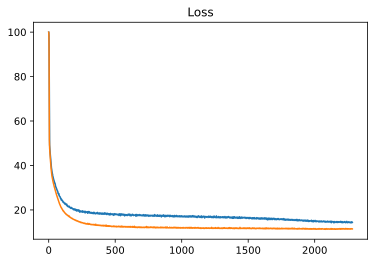

In [128]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [ ]:
model.load_weights(PATH +'best_model.hdf5')
model.save(DATA_PATH + 'nn_1.hdf5') #очень хороший результат 11.14 на Kaggle

In [129]:
test_predict_nn1 = model.predict(X_test)
#test_predict_nn1 = np.exp(model.predict(X_test)) # антилогарифм добавлен!!!!!!

print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 11.28%


best 11.25  \ 11.33% надо сократить кол-во  NAME признак (может урезать названия?)





In [130]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv(DATA_PATH + 'nn1_submission-best2.csv', index=False)

In [131]:
sample_submission['price']

0       5.902094e+05
1       2.465215e+06
2       6.364380e+05
3       4.913460e+05
4       2.650367e+06
            ...     
1666    1.059339e+06
1667    2.600524e+06
1668    1.526145e+06
1669    1.086731e+06
1670    9.988593e+05
Name: price, Length: 1671, dtype: float32

Рекомендации для улучшения Model 3:    
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'), поэтому эти данные можно удалить. Затем следует еще сильнее сократить размерность, например, выделив наличие xDrive в качестве отдельного признака.

# Model 4: NLP + Multiple Inputs

In [132]:

data.description 

0       Всем привет!\n\nПродам эксклюзивный проект 124...
1       Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2       Машина тут продаётся не в первый раз, НО! Толь...
3       Автомобиль в отличном состоянии, весь в родной...
4       Немка! с бесключивым доступом и камерой заднег...
                              ...                        
8348    Продаётся любимый автомобиль! За годы эксплуат...
8349    Куплена у официального дилера в 2017 г. \n\nТр...
8350    Торг на месте. Все работает. Сборка немецкая. ...
8351    Автомобиль в отличном состоянии.\n3-из Авто в ...
8352    Удлиненный заводской Pullman на базе W140 (воо...
Name: description, Length: 8353, dtype: object

In [ ]:
# Приступим к токенизации. 

# ВАРИАНТ 1

# Но  сперва создадим список СТОП слов (загрузим его и дополним).
# надо сделать  чистку Description и удалить все неважные.

In [134]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [135]:

stopwords = stopwords.words("russian")
stopwords

['и',
 'в',
 'во',
 'не',
 'что',
 'он',
 'на',
 'я',
 'с',
 'со',
 'как',
 'а',
 'то',
 'все',
 'она',
 'так',
 'его',
 'но',
 'да',
 'ты',
 'к',
 'у',
 'же',
 'вы',
 'за',
 'бы',
 'по',
 'только',
 'ее',
 'мне',
 'было',
 'вот',
 'от',
 'меня',
 'еще',
 'нет',
 'о',
 'из',
 'ему',
 'теперь',
 'когда',
 'даже',
 'ну',
 'вдруг',
 'ли',
 'если',
 'уже',
 'или',
 'ни',
 'быть',
 'был',
 'него',
 'до',
 'вас',
 'нибудь',
 'опять',
 'уж',
 'вам',
 'ведь',
 'там',
 'потом',
 'себя',
 'ничего',
 'ей',
 'может',
 'они',
 'тут',
 'где',
 'есть',
 'надо',
 'ней',
 'для',
 'мы',
 'тебя',
 'их',
 'чем',
 'была',
 'сам',
 'чтоб',
 'без',
 'будто',
 'чего',
 'раз',
 'тоже',
 'себе',
 'под',
 'будет',
 'ж',
 'тогда',
 'кто',
 'этот',
 'того',
 'потому',
 'этого',
 'какой',
 'совсем',
 'ним',
 'здесь',
 'этом',
 'один',
 'почти',
 'мой',
 'тем',
 'чтобы',
 'нее',
 'сейчас',
 'были',
 'куда',
 'зачем',
 'всех',
 'никогда',
 'можно',
 'при',
 'наконец',
 'два',
 'об',
 'другой',
 'хоть',
 'после',
 'на

In [136]:
len(stopwords)

151

In [137]:
# Дополним список СТОП слов (можно добавить любые слова):
stopwords.extend(['что', 'это', '2017', 'вот', 'быть', 'как', 'в',     '•',
 'и', 'с',
 'на', 'не',
 'по', 'все', 'для',
 'от', 'в', 'до', 'при', 'у',
 '2', 'без',
 'за','то',
 'есть', '1',
 'года',
 'только',
 '6',
 'км',
 'лет',
 '3',

 'а',
 'мы',
 '9' ,
 'вас',
 '5',
 '–',
 'м',
 '∙',
 'я',
 'ваш',
 '4',
 'вы',
 '7',
 'm',
 'к',
 '00', 'год',
 '10',
 '8',
 '—',
              
 'л',
 'всех', 'in',
 'о', 'руб', 'т',
 'же',

 'ни',
  'под',
 'можете',
 'была',
 'д',
 'тыс',
 '0',
 's',

 'час',


 'вся',

 'всё',

 'наш',
 'г',

 '30',

 '11',


 'если',

 'возможна',

 'это',

 'предложение',

 'рублей',

 'себя',



 '☑️',


 'нам',


 '50',
 
 'ин',

 'c',




 'во',

 '✔',






 'х',


 '➥',

 
 '40',
 'ряд',

 'этого',

 '2018',

 '13',

 '●',


 'эл',

 'ти',

 '25',

 'могу',

 '01',
 'fi',

 '·',

 '2014',

 '✅',
 'ещё',


 'кредиту',
 'й',
 'дверь',

 'б',

 'позвоните',

 '72',

 'гк',
 'сел',
 'поехал',

 'ооо',

 '☛',
 'раз',

 'i',


 '60',


 '«гарантия',


 'р',

 'кто',

 'тд',

 '2013',
 'мне',

 'там',
 'информации',
 '2016',
 'лицо',
 'еще',
 
 '2012',


 'оф',


 ])

In [138]:
len(stopwords)

283

In [139]:
# для чистки стоп слов в Desrciption
def filter_str(st):
    split_str = st.split()
    filtered_str = ' '.join((filter(lambda s: s not in stopwords, split_str)))
    return filtered_str
data['description_filtered'] = data['description'].apply(filter_str)

In [140]:
data['description_filtered'].unique()

array(['Всем привет! Продам эксклюзивный проект 124 универсал 300TE-24 SportLine Модель 124.091 300 TE-24 Двигатель 104.980 Трансмиссия 722.359 Цвет кузова 040 (черный) Отделка салона 271 (Кожа черная / "антрацит") Опции: 211 Автоматическая блокировка дифференциала (ASD) 240 Индикатор внешней температуры 244 Спортивные сиденья спереди 281 Спортивное рулевое колесо отделкой кожи (диаметр 390 мм) кожаный рычаг КПП 291 Подушка безопасности водителя переднего пассажира 300 Дополнительный бардачок вещевом отсеке спереди 412 Люк электроприводом устройством подъёма 420 Автоматическая коробка передач, напольное исполнение 440 Темпомат (круиз-контроль) 538 Автоматическая антенна 541 Двойные занавески багажного пространства пасажирского отсека (сетка/шторка) 570 Складной подлокотник спереди 586 Кондиционер Behr электрические стеклоподъемники передних задних дверей 598 Атермальные боковые заднее стекла, заднее стекло подогревом (ESG) 650 Спортивная подвеска 673 АКБ увеличенной мощности 812 Устано

In [141]:
data['description'] = data['description_filtered']
data['description']

0       Всем привет! Продам эксклюзивный проект 124 ун...
1       Продаю любимейшую тачилу.. Обвес тюнинг Hamman...
2       Машина продаётся первый раз, НО! Только что: П...
3       Автомобиль отличном состоянии, весь родной кра...
4       Немка! бесключивым доступом камерой заднего ви...
                              ...                        
8348    Продаётся любимый автомобиль! За годы эксплуат...
8349    Куплена официального дилера г. Третий владелец...
8350    Торг месте. Все работает. Сборка немецкая. Рез...
8351    Автомобиль отличном состоянии. 3-из Авто семье...
8352    Удлиненный заводской Pullman базе W140 (вообще...
Name: description, Length: 8353, dtype: object

In [142]:
def preprocess_text(sen):
    # Removing html tags
    #sentence = remove_tags(sen)
    sentence = sen
    # Remove punctuations and numbers
    #sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ',  sentence)

    return sentence

In [143]:
data['description2'] = data['description'].apply(preprocess_text)

In [144]:
data['description2'][2]

'Машина продаётся первый раз, НО! Только что: Перебран двигатель заменой колец, колпаков, ванос, цепь, проклади др. Покрашена вся, кроме багажника крыши (причина покраски - потёртости сколы, битая) Сделаны работы ходовой (рычаги, амортизаторы др) Поменяно масло АКПП Раздатка Вырезаны катализаторы (немного рычит) Куча мелких работ, обновление прошивки. Для тех, хочет вкладывать деньги! Общая стоимость работы составила 300 000 рублей. Есть документы сервиса. Хорошая комплектация : кожа, полный привод!, датчик дождя света, помощь спуске горки. Установлена штатная медиасистема экраном +камера заднего вида. Минусы : рычит низах, удаления катов( легко исправить, многим нравится) Ошибка корректору фар (нужно поменять датчики, сами фары работают) Машина подвоха! Идеальный внешний вид прекрасное техническое состояние! Торг минимальный.'

In [145]:
data['description'].nunique()

7641

Сделаем лемматизацию текста в признаке data['description']


In [146]:
# импортируем библиотеку для лемматизации на РУССКОМ
!pip install pymorphy2
# и словарь подгружаем РУССКОМ
!pip install -U pymorphy2-dicts-ru

Requirement already up-to-date: pymorphy2-dicts-ru in /usr/local/lib/python3.6/dist-packages (2.4.417127.4579844)


In [147]:
# пример работы модуля
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
word = morph.parse('доллар')[0]
v1, v2, v3 = word.inflect({'sing', 'nomn'}), word.inflect({'gent'}), word.inflect({'plur', 'gent'})
 
print(v1.word, v2.word, v3.word)  # доллар доллара долларов

доллар доллара долларов


In [148]:
data['description'][111]

'КОМПЛЕКТАЦИЯ: панорамная крыша, камера заднего вида, навигационная система, проэкция лобовое стекло, спорт сидения , внешний М пакет , М руль. Хорошее состояние, доступная цена. Тойота Центр Кунцево официальный дилер! У представлено 600 автомобилей пробегом 500 комплектов шин, дисков, колес сборе. Мы подготовили Вас несколько акций: Акция №1 Максимально выгодный кредит авто пробегом 9,5% (одобрение 2х часов, минимальный комплект документов), сделка день день. + бонус 000 руб. Наши банки-партнеры: 1. Банк ВТБ (ПАО) 2. ООО «Русфинанс Банк» 3. АО «Кредит Европа Банк (Россия)» 4. ПАО "БАНК УРАЛСИБ" 5. АО «ЮниКредит Банк» 6. ООО «Фольксваген Банк Рус» 7. ПАО "Совкомбанк" 8. АО «Тойота Банк» 9. АО «МС Банк Рус» 10. Банк Зенит (ПАО) 11. «Сетелем Банк» ООО 12. КБ «ЛОКО-Банк» (АО) 13. АО "РН Банк" 14. ПАО "Росгосстрах Банк" Акция №2 Сдайте свой автомобиль - компенсируем 10% Максимальная выгода 000 руб. Акция №3 Сделайте ТО, слесарный кузовной ремонт приобретаемый Вами автомобиль пробегом скидк

In [149]:
data['description'][index]

'БЕЗ ДТП. РАСЧЕТНЫЕ РАБОТЫ НЕ ПРОИЗВОДИЛИСЬ! ПТС ОРИГИНАЛ. Автомобиль покупался официального дилера наличный расчет. По птс год. РЕСТАЙЛИНГ. Два владельца. ДВА КЛЮЧА РОДНОЙ ПРОБЕГ В ДТП автомобиль участвовал. Автомобиль РОДНОЙ КРАСКЕ. Все стекла родные, включая лобовое Салон отличном состоянии, потерт, прокурен. VIN номер маркировочные таблички соответствуют требованиям завода-изготовителя, изменениям подвергались. Обслуживание производилось согласно регламенту. На пробеге 142.000 сделано ТО: масло ДВС, ВСЕ фильтра, катушки зажигания, свечи. Замена комплекта ГРМ произведена пробеге 110.000 прокладка клапанной крышки. ИСТОРИЯ АВТОМОБИЛЯ ПОЛНОСТЬЮ ПРОЗРАЧНА!!!! КОМПЛЕКТАЦИЯ: - легкосплавные диски V-spoke 236: 225/55 R17 - кожаный руль - АКПП - биксеноновые фары - светодиодные задние фонари - функция Auto Start Stop - датчик света - датчики дождя - боковые зеркала повторителями указателей поворота - автоматическая коррекция угла наклона фар - электропривод боковых зеркал - электроподогрев

In [150]:
line = ("Продаю любимейшую тачилу.. Обвес тюнинг Hamman")
for word in line.split():
    print(morph.parse(word)[0].normal_form)

продавать
любимый
тачилу..
обвес
тюнинг
hamman


In [151]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
def filter_str(str):
    split_str = str.split()
    filtered_str = ' '.join((map(lambda s: morph.parse(s)[0].normal_form , split_str)))
    return filtered_str
data['description'] = data['description'].apply(filter_str)

In [152]:
data['description']

0       весь привет! продать эксклюзивный проект 124 у...
1       продавать любимый тачилу.. обвес тюнинг hamman...
2       машина продаваться первый раз, но! только что:...
3       автомобиль отличный состоянии, весь родный кра...
4       немка! бесключивый доступ камера задний вида. ...
                              ...                        
8348    продаваться любимый автомобиль! за год эксплуа...
8349    купить официальный дилер г. третий владелец, в...
8350    торг месте. всё работает. сборка немецкая. рез...
8351    автомобиль отличный состоянии. 3-из авто семья...
8352    удлинённый заводский pullman база w140 (вообще...
Name: description, Length: 8353, dtype: object

In [153]:
# вариант 2 фильтрования: 
#"""
#def to_normal_form(string):
#    return morph.parse(string)[0].normal_form
#def filter_str(str):
#    split_str = [to_normal_form(token) for token in str.split()]
#   filtered_str = ' '.join(split_str)
#    return filtered_str
#""""

In [154]:
#data['description'] = data['description_filtered'] 
#data['description'] 

In [155]:
# Вариант 2: Создадим список ХОРОШИХ слов\ выражений (нужно хорошенько создать список слов, иначе ерудна будет!!!)

goodwords  = ('Антипробуксовочная система (ASR)', 'Система стабилизации (ESP)', 'Подушка безопасности водителя', 'Крепление детского кресла (задний ряд) ISOFIX',
              'Подушки безопасности оконные (шторки)', 'Подушка безопасности пассажира', 'Подушки безопасности боковые задние', 'Подушки безопасности боковые', 
              'Датчик давления в шинах', 'Антиблокировочная система (ABS)', 'Блокировка замков задних дверей', 'Подушка безопасности для защиты коленей водителя', 
              'Система «старт-стоп»', 'Электростеклоподъёмники передние', 'Мультифункциональное рулевое колесо', 'Прикуриватель и пепельница', 'Бортовой компьютер',
              'Усилитель руля', 'Электропривод зеркал', 'Электростеклоподъёмники задние', 'Парктроник передний', 'Регулировка руля по вылету', 'Климат-контроль 2-зонный',
              'Электроскладывание зеркал', 'Парктроник задний', 'AUX', 'USB', 'Аудиосистема', 'Bluetooth', 'Датчик света', 'Автоматический корректор фар', 'Омыватель фар', 
              'Датчик дождя', 'Электрообогрев боковых зеркал', 'Светодиодные фары', 'Регулировка передних сидений по высоте', 'Передний центральный подлокотник', 
              'Складывающееся заднее сиденье', 'Электрорегулировка передних сидений', 'Тёмный салон', 'Кожа (Материал салона)', 'Обогрев рулевого колеса', 'Подогрев передних сидений',
              'Отделка кожей рулевого колеса', 'Центральный замок', 'Иммобилайзер', 'Круиз-контроль', 'Система автоматической парковки', 'Камера задняя', 'Активный усилитель руля',
              'Климат-контроль многозонный', 'Система доступа без ключа', 'Запуск двигателя с кнопки', 'Электропривод крышки багажника', 'Регулировка руля по высоте', 
              'Система помощи при торможении (BAS, EBD)', 'ЭРА-ГЛОНАСС', 'Система помощи при старте в гору (HSA)', 'Аудиосистема Hi-Fi', 'Розетка 12V', 'Спортивные передние сиденья',
              'Декоративная подсветка салона', 'Накладки на пороги', 'Комбинированный (Материал салона)', 'Третий задний подголовник', 'Электрообогрев форсунок стеклоомывателей', 
              'Дневные ходовые огни', 'Противотуманные фары', 'Диски 18', 'Металлик', 'Открытие багажника без помощи рук', 'Доводчик дверей', 'Проекционный дисплей', 
              'Дистанционный запуск двигателя', 'Электронная приборная панель', 'Климат-контроль 1-зонный', 'Система адаптивного освещения', 'Система управления дальним светом', 
              'Электрообогрев лобового стекла', 'Навигационная система', 'Беспроводная зарядка для смартфона', 'Мультимедиа система для задних пассажиров', 'Голосовое управление', 'Люк',
              'Подогрев задних сидений', 'Память передних сидений', 'Вентиляция передних сидений', 'Количество мест: 5', 'Вентиляция задних сидений', 'Светлый салон', 
              'Подрулевые лепестки переключения передач', 'Ксеноновые/Биксеноновые фары', 'Диски 19', 'Электрорегулировка руля', 'Камера 360°', 'Аудиоподготовка', 'Прочее',
              'Защита картера', 'Ткань (Материал салона)', 'Тонированные стекла', 'Панорамная крыша / лобовое стекло', 'Рейлинги на крыше', 'Легкосплавные диски', 'Диски 17', 
              'Сигнализация', 'Докатка', 'Отделка кожей рычага КПП', 'Электрообогрев зоны стеклоочистителей', 'Рулевая колонка с памятью положения', 'Диски 20', 'Аудиосистема с TV',
              'Датчик проникновения в салон (датчик объема)', 'Декоративные молдинги', 'Полноразмерное запасное колесо', 'Количество мест: 4', 'Активная подвеска', 
              'Электрорегулировка сиденья водителя', 'Регулировка сиденья водителя по высоте', 'Память сиденья водителя', 'Система помощи при спуске', 'Охлаждаемый перчаточный ящик', 
              'Датчик усталости водителя', 'Функция складывания спинки сиденья пассажира', 'Солнцезащитная шторка на заднем стекле', 'Солнцезащитные шторки в задних дверях',
              'Сиденья с массажем', 'CarPlay', 'Программируемый предпусковой отопитель', 'Отделка потолка чёрной тканью', 'Декоративные накладки на педали', 'Обвес кузова', 
              'Количество мест: 2', 'Стальные диски', 'Крепление детского кресла (передний ряд) ISOFIX', 'Адаптивный круиз-контроль', 'Система выбора режима движения', 
              'Искусственная кожа (Материал салона)', 'Диски 16', 'Система контроля за полосой движения', 'Система предотвращения столкновения', 'Система контроля слепых зон', 
              'Третий ряд сидений', 'Диски 21', 'Пневмоподвеска', 'Кондиционер', 'Регулируемый педальный узел', 'Система распознавания дорожных знаков', 'Система ночного видения', 
 'Электрорегулировка задних сидений', 'Лазерные фары', 'Спортивная подвеска', 'Система стабилизации рулевого управления (VSM)', 'Android Auto', 'Розетка 220V', 'Фаркоп', 'Диски 15', 
 'Диски 22', 'Количество мест: 7', 'Алькантара (Материал салона)', 'Яндекс.Авто', 'Сигнализация с обратной связью', 'Складной столик на спинках передних сидений', 'Велюр (Материал салона)', 
 'Ламинированные боковые стекла', 'Бронированный кузов', 'Аэрография', 'Камера передняя', 'Количество мест: 6', 'Газобаллонное оборудование', 'Диски 14')

In [156]:
 # cделаем разбивку Хороших слов.
new_list = []
for st in goodwords:
  split_str = st.split()
  new_list.append(split_str)


In [157]:
print(str)

<class 'str'>


In [158]:
# приведем к единому списку:
def listmerge1(lstlst):
    all=[]
    for lst in lstlst:
        for el in lst:
            all.append(el)
    return all
goodlist = listmerge1(new_list)

In [159]:
# сделаем все с маленькой буквы:
new_list_low = []
for word in goodlist:
  word1 = word.lower() 
  new_list_low.append(word1)


In [160]:
new_list_low

['антипробуксовочная',
 'система',
 '(asr)',
 'система',
 'стабилизации',
 '(esp)',
 'подушка',
 'безопасности',
 'водителя',
 'крепление',
 'детского',
 'кресла',
 '(задний',
 'ряд)',
 'isofix',
 'подушки',
 'безопасности',
 'оконные',
 '(шторки)',
 'подушка',
 'безопасности',
 'пассажира',
 'подушки',
 'безопасности',
 'боковые',
 'задние',
 'подушки',
 'безопасности',
 'боковые',
 'датчик',
 'давления',
 'в',
 'шинах',
 'антиблокировочная',
 'система',
 '(abs)',
 'блокировка',
 'замков',
 'задних',
 'дверей',
 'подушка',
 'безопасности',
 'для',
 'защиты',
 'коленей',
 'водителя',
 'система',
 '«старт-стоп»',
 'электростеклоподъёмники',
 'передние',
 'мультифункциональное',
 'рулевое',
 'колесо',
 'прикуриватель',
 'и',
 'пепельница',
 'бортовой',
 'компьютер',
 'усилитель',
 'руля',
 'электропривод',
 'зеркал',
 'электростеклоподъёмники',
 'задние',
 'парктроник',
 'передний',
 'регулировка',
 'руля',
 'по',
 'вылету',
 'климат-контроль',
 '2-зонный',
 'электроскладывание',
 'зерка

In [161]:
data['description'][345]

'год выпуска: 2016. пробег: 000 км. кузов: седан. цвет: белый. двигатель: 3.0 / 265 л.с. / дизель. налог: 39 750 ₽ / год. коробка: автоматическая. привод: полный. руль: левый. состояние: не требовать ремонта. владельцы: более. птс: оригинал. таможня: растаможен. vin: wba**************. госномер: ******|750.'

In [162]:
# для чистки Хороших  слов в Desrciption (надо доработать, чтобы выражения отсеивал!!!!)
def filter_str(st):
    split_str = st.split()
    filtered_str = ' '.join((filter(lambda s: s in new_list_low, split_str)))
    return filtered_str
data['description_filtered3'] = data['description'].apply(filter_str)

In [163]:
#data['description'] = data['description_filtered3']

In [164]:
#  Выбираем вариант 1 по фильтрации текста (т.к. он показал лучше результат)
#data['description']=data['description_filtered3']

In [165]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 50000  # 10000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 200

In [166]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

In [167]:
text_train

6413    двс акпп отличный состояние салон отличный сос...
6692    покупать новый дилера, тех. состояние отличное...
4148    американка. продажа снятие учёт день покупки. ...
4009    хороший, комфортный автомобиль. вложение требу...
2470    автомобиль побояться слово идеальный состояние...
                              ...                        
5443    идеальный состояние...!!! ни один красить дета...
6862    рольф премиум крупный официальный дилер москва...
6897    s-lin аlkantara хороший состоянии, сидeние пaм...
7061    продаваться собственником. в птс хозяин. гаран...
2531    «inchcape certified- первый международный офиц...
Name: description, Length: 5345, dtype: object

### Tokenizer

In [168]:
# Приступим к токенизации. 

In [169]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenize.fit_on_texts(data.description)

CPU times: user 1.07 s, sys: 0 ns, total: 1.07 s
Wall time: 1.08 s


In [170]:
#tokenize.index_word[1:100:]

In [171]:
dir(tokenize)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_keras_api_names',
 '_keras_api_names_v1',
 'char_level',
 'document_count',
 'filters',
 'fit_on_sequences',
 'fit_on_texts',
 'get_config',
 'index_docs',
 'index_word',
 'lower',
 'num_words',
 'oov_token',
 'sequences_to_matrix',
 'sequences_to_texts',
 'sequences_to_texts_generator',
 'split',
 'texts_to_matrix',
 'texts_to_sequences',
 'texts_to_sequences_generator',
 'to_json',
 'word_counts',
 'word_docs',
 'word_index']

In [172]:
tokenize.word_counts

OrderedDict([('весь', 986),
             ('привет', 15),
             ('продать', 577),
             ('эксклюзивный', 170),
             ('проект', 17),
             ('124', 7),
             ('универсал', 30),
             ('300te', 1),
             ('24', 133),
             ('sportline', 6),
             ('модель', 153),
             ('091', 1),
             ('300', 99),
             ('te', 1),
             ('двигатель', 1830),
             ('104', 3),
             ('980', 3),
             ('трансмиссия', 26),
             ('722', 6),
             ('359', 2),
             ('цвет', 1117),
             ('кузов', 1529),
             ('040', 1),
             ('черный', 117),
             ('отделка', 944),
             ('салон', 5308),
             ('271', 8),
             ('кожа', 1383),
             ('чёрный', 1437),
             ('антрацит', 229),
             ('опции', 65),
             ('211', 31),
             ('автоматический', 1275),
             ('блокировка', 280),
             (

In [173]:
tokenize.word_index

{'автомобиль': 1,
 'система': 2,
 'задний': 3,
 'пробег': 4,
 'салон': 5,
 'сидение': 6,
 'передний': 7,
 'машина': 8,
 'в': 9,
 'комплект': 10,
 'официальный': 11,
 'кредит': 12,
 'диск': 13,
 'ваш': 14,
 'новый': 15,
 'авто': 16,
 'состояние': 17,
 'пакет': 18,
 'фара': 19,
 'безопасность': 20,
 'руль': 21,
 'колесо': 22,
 'дилер': 23,
 'гарантия': 24,
 'состоянии': 25,
 'птс': 26,
 'обмен': 27,
 'контроль': 28,
 'комплектация': 29,
 'bmw': 30,
 '000': 31,
 'вы': 32,
 'всё': 33,
 'полный': 34,
 'покупка': 35,
 'зеркало': 36,
 'то': 37,
 'датчик': 38,
 'продажа': 39,
 'отличный': 40,
 'с': 41,
 'автомобиля': 42,
 'водитель': 43,
 'подушка': 44,
 'шина': 45,
 'пассажир': 46,
 'двигатель': 47,
 'два': 48,
 'на': 49,
 'подогрев': 50,
 'любой': 51,
 'обогрев': 52,
 'юридический': 53,
 'проверка': 54,
 'обслуживание': 55,
 'хороший': 56,
 'технический': 57,
 'оригинал': 58,
 'по': 59,
 'резина': 60,
 'торг': 61,
 'масло': 62,
 'один': 63,
 'замена': 64,
 'рулевой': 65,
 'владелец': 66,
 'у

In [174]:
#tknz = tokenize.word_index.keys() 
# tknz

In [175]:
len(tokenize.word_index)

31751

In [176]:
#filtered_tokens = []
#for token in tknz:
 #   if token not in stopwds:
 #       filtered_tokens.append(token)
#filtered_tokens

In [177]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5345, 200) (1337, 200) (1671, 200)
CPU times: user 962 ms, sys: 0 ns, total: 962 ms
Wall time: 961 ms


In [178]:
text_train_sequences

array([[    0,     0,     0, ...,  3015, 27804, 27805],
       [    0,     0,     0, ...,   976,   283,   456],
       [    0,     0,     0, ...,  1061,    61,  1689],
       ...,
       [    0,     0,     0, ...,  3231,    15,  5286],
       [    0,     0,     0, ...,    60,    74,   448],
       [    0,     0,     0, ...,    10,   937,   251]], dtype=int32)

In [179]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

плюс комплект зимний резины. сборка - германия. пробег родной. автомобиль отличный состоянии. своевременный обслуживание. заменить vanоса профильный сервисе, двигатель масло расходует. замена масло фильтр неделя назад. двигатель работать ровно. акпп работать плавно четко. собственник. без торга.
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0    

### RNN NLP

In [180]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.4))
#model_nlp.add(L.BatchNormalization())  , -?нужен тут
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.45))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

### MLP

In [181]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.7))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.6))

### Multiple Inputs NN

In [182]:
# можно проверить модель только с тектсом (без MLP)!!!! - хуже результат!!!

In [183]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output]) 
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
#head = L.Dropout(0.7)   # моя вставка (тест!!!!)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [184]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 200)     6350400     seq_description[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 200, 256)     467968      embedding[0][0]                  
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 200, 256)     0           lstm[0][0]                       
_______________________________________________________________________________________

### Fit

class Adadelta: Optimizer that implements the Adadelta algorithm.

class Adagrad: Optimizer that implements the Adagrad algorithm.

class Adam: Optimizer that implements the Adam algorithm.

class Adamax: Optimizer that implements the Adamax algorithm.

class Ftrl: Optimizer that implements the FTRL algorithm.

class Nadam: Optimizer that implements the NAdam algorithm.

class Optimizer: Base class for Keras optimizers.

class RMSprop: Optimizer that implements the RMSprop algorithm.

class SGD: Gradient descent (with momentum) optimizer.

In [185]:
optimizer = tf.keras.optimizers.Adamax(0.004) #0.003 Adamax Adam
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [186]:
checkpoint = ModelCheckpoint('best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=30, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [187]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
11/11 [==============================] - 3s 244ms/step - loss: 99.9981 - MAPE: 99.9981 - val_loss: 99.9915 - val_MAPE: 99.9915
Epoch 2/500
11/11 [==============================] - 2s 173ms/step - loss: 99.9751 - MAPE: 99.9751 - val_loss: 99.9365 - val_MAPE: 99.9365
Epoch 3/500
11/11 [==============================] - 2s 169ms/step - loss: 99.8743 - MAPE: 99.8743 - val_loss: 99.7462 - val_MAPE: 99.7462
Epoch 4/500
11/11 [==============================] - 2s 179ms/step - loss: 99.5795 - MAPE: 99.5795 - val_loss: 99.2578 - val_MAPE: 99.2578
Epoch 5/500
11/11 [==============================] - 2s 170ms/step - loss: 98.8744 - MAPE: 98.8744 - val_loss: 98.2200 - val_MAPE: 98.2200
Epoch 6/500
11/11 [==============================] - 2s 173ms/step - loss: 97.4976 - MAPE: 97.4976 - val_loss: 96.2164 - val_MAPE: 96.2164
Epoch 7/500
11/11 [==============================] - 2s 190ms/step - loss: 94.9368 - MAPE: 94.9368 - val_loss: 92.7453 - val_MAPE: 92.7453
Epoch 8/500
11/11 [========

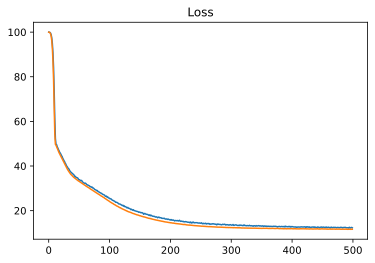

In [188]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [189]:
model.load_weights('best_model.hdf5')
model.save(DATA_PATH+ 'nn_mlp_nlp.hdf5')

In [190]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 11.65%


best = 11.62%

In [191]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv(DATA_PATH + 'nn2_submission3.csv', index=False)

Идеи для улучшения NLP части:
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например, сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста

# Model 5: Добавляем картинки

### Data

In [192]:
import zipfile
import PIL
from PIL import ImageOps, ImageFilter

print('Распаковываем картинки')
# Will unzip the files so that you can see them.
for data_zip in ['img.zip']:
    with zipfile.ZipFile(DATA_PATH +data_zip,"r") as z:
        z.extractall(PATH)
        
print(os.listdir(PATH))

Распаковываем картинки
['.config', 'best_model.hdf5', 'requirements.txt', 'catboost_info', 'img', '__MACOSX', 'drive', 'sample_data']


In [193]:
#!ls "/content/img/img/"

In [194]:
!ls PATH+"/img/img/1098265596.jpg"

ls: cannot access 'PATH+/img/img/1098265596.jpg': No such file or directory


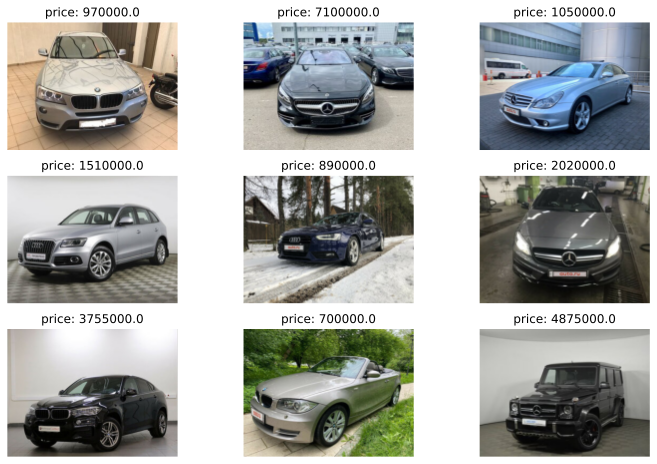

In [195]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH +"/img/img/" + str (path) + ".jpg")
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [196]:
#print(str)

In [197]:
size = (320, 240) #(320, 240)- виснет:(480, 360)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread("/content/img/img/" + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5345, 240, 320, 3) dtype uint8
images shape (1337, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


### albumentations

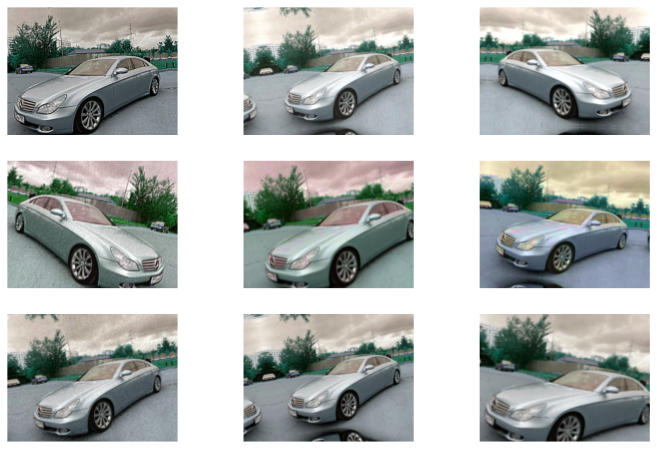

In [198]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


#пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.3),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.2),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.2),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [199]:
#!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

In [200]:
def make_augmentations(images):
  print('применение аугментаций', end = '')
  augmented_images = np.empty(images.shape)
  for i in range(images.shape[0]):
    if i % 200 == 0:
      print('.', end = '')
    augment_dict = augmentation(image = images[i])
    augmented_image = augment_dict['image']
    augmented_images[i] = augmented_image
  print('')
  return augmented_images

## tf.data.Dataset
Если все изображения мы будем хранить в памяти, то может возникнуть проблема ее нехватки. Не храните все изображения в памяти целиком!

Метод .fit() модели keras может принимать либо данные в виде массивов или тензоров, либо разного рода итераторы, из которых наиболее современным и гибким является [tf.data.Dataset](https://www.tensorflow.org/guide/data). Он представляет собой конвейер, то есть мы указываем, откуда берем данные и какую цепочку преобразований с ними выполняем. Далее мы будем работать с tf.data.Dataset.

Dataset хранит информацию о конечном или бесконечном наборе кортежей (tuple) с данными и может возвращать эти наборы по очереди. Например, данными могут быть пары (input, target) для обучения нейросети. С данными можно осуществлять преобразования, которые осуществляются по мере необходимости ([lazy evaluation](https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BD%D0%B8%D0%B2%D1%8B%D0%B5_%D0%B2%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)).

`tf.data.Dataset.from_tensor_slices(data)` - создает датасет из данных, которые представляют собой либо массив, либо кортеж из массивов. Деление осуществляется по первому индексу каждого массива. Например, если `data = (np.zeros((128, 256, 256)), np.zeros(128))`, то датасет будет содержать 128 элементов, каждый из которых содержит один массив 256x256 и одно число.

`dataset2 = dataset1.map(func)` - применение функции к датасету; функция должна принимать столько аргументов, каков размер кортежа в датасете 1 и возвращать столько, сколько нужно иметь в датасете 2. Пусть, например, датасет содержит изображения и метки, а нам нужно создать датасет только из изображений, тогда мы напишем так: `dataset2 = dataset.map(lambda img, label: img)`.

`dataset2 = dataset1.batch(8)` - группировка по батчам; если датасет 2 должен вернуть один элемент, то он берет из датасета 1 восемь элементов, склеивает их (нулевой индекс результата - номер элемента) и возвращает.

`dataset.__iter__()` - превращение датасета в итератор, из которого можно получать элементы методом `.__next__()`. Итератор, в отличие от самого датасета, хранит позицию текущего элемента. Можно также перебирать датасет циклом for.

`dataset2 = dataset1.repeat(X)` - датасет 2 будет повторять датасет 1 X раз.

Если нам нужно взять из датасета 1000 элементов и использовать их как тестовые, а остальные как обучающие, то мы напишем так:

`test_dataset = dataset.take(1000)
train_dataset = dataset.skip(1000)`

Датасет по сути неизменен: такие операции, как map, batch, repeat, take, skip никак не затрагивают оригинальный датасет. Если датасет хранит элементы [1, 2, 3], то выполнив 3 раза подряд функцию dataset.take(1) мы получим 3 новых датасета, каждый из которых вернет число 1. Если же мы выполним функцию dataset.skip(1), мы получим датасет, возвращающий числа [2, 3], но исходный датасет все равно будет возвращать [1, 2, 3] каждый раз, когда мы его перебираем.

tf.Dataset всегда выполняется в graph-режиме (в противоположность eager-режиму), поэтому либо преобразования (`.map()`) должны содержать только tensorflow-функции, либо мы должны использовать tf.py_function в качестве обертки для функций, вызываемых в `.map()`. Подробнее можно прочитать [здесь](https://www.tensorflow.org/guide/data#applying_arbitrary_python_logic).

In [201]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [202]:
size = (320, 240)

In [203]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
  return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

### Строим сверточную сеть для анализа изображений без "головы"

Надо построить просто сеть  для картинок без мультиинпут!!!

In [204]:
import tensorflow as tf
#нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

In [205]:
#строим нейросеть для анализа табличных данных
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(512, activation = 'relu'),
    L.Dropout(0.7),
    L.BatchNormalization(),
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.6),
    ])

In [206]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.7),
    L.LSTM(128),
    L.Dropout(0.45),
    L.Dense(64),
    ])

In [207]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)  #combinedInput
L.Dropout(0.7) # добавил
#head = L.Dense(128, activation="relu") # добавил
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head) #inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [208]:
optimizer = tf.keras.optimizers.Adamax(0.003) #Adamax
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [209]:
checkpoint = ModelCheckpoint('best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=15, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [210]:
train_dataset

<MapDataset shapes: (((240, 320, 3), (431,), <unknown>), ()), types: ((tf.uint8, tf.float64, tf.int32), tf.float64)>

In [211]:
test_dataset

<MapDataset shapes: (((240, 320, 3), (431,), <unknown>), ()), types: ((tf.uint8, tf.float64, tf.int32), tf.float64)>

In [223]:
history = model.fit(train_dataset.batch(30),  #тут можно батчсайз  уменьшить  для В6 
                    epochs=100,#100
                    validation_data = test_dataset.batch(30), #тут можно батчсайз  уменьшить  для В6 
                    callbacks=callbacks_list
                   )

Epoch 1/100
179/179 [==============================] - 112s 625ms/step - loss: 19.3238 - MAPE: 19.3238 - val_loss: 15.1540 - val_MAPE: 15.1540
Epoch 2/100
179/179 [==============================] - 118s 657ms/step - loss: 19.2776 - MAPE: 19.2776 - val_loss: 15.0926 - val_MAPE: 15.0926
Epoch 3/100
179/179 [==============================] - 111s 622ms/step - loss: 19.2985 - MAPE: 19.2985 - val_loss: 16.0160 - val_MAPE: 16.0160
Epoch 4/100
179/179 [==============================] - 111s 619ms/step - loss: 18.8375 - MAPE: 18.8375 - val_loss: 15.5060 - val_MAPE: 15.5060
Epoch 5/100
179/179 [==============================] - 115s 641ms/step - loss: 19.2094 - MAPE: 19.2094 - val_loss: 14.5957 - val_MAPE: 14.5957
Epoch 6/100
179/179 [==============================] - 112s 623ms/step - loss: 18.9260 - MAPE: 18.9260 - val_loss: 16.3100 - val_MAPE: 16.3100
Epoch 7/100
179/179 [==============================] - 110s 613ms/step - loss: 18.9464 - MAPE: 18.9464 - val_loss: 19.7525 - val_MAPE: 19.7525

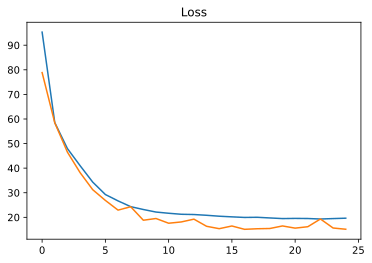

In [213]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [214]:
model.load_weights('best_model.hdf5')
model.save(DATA_PATH +'nn_final.hdf5')

In [215]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 15.16%


In [216]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv(DATA_PATH +'nn3_submission1.csv', index=False)


#### Общие рекомендации:
* Попробовать разные архитектуры
* Провести более детальный анализ результатов
* Попробовать различные подходы в управление LR и оптимизаторы
* Поработать с таргетом
* Использовать Fine-tuning

#### Tabular
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'). Можно удалить эти данные. Затем можно еще сильнее сократить размерность, например выделив наличие xDrive в качестве отдельного признака.

* Поработать над Feature engineering



#### NLP
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста



#### CV
* Попробовать различные аугментации
* Fine-tuning

# Blend

In [228]:
blend_predict = (test_predict_catboost + test_predict_nn1[:,0]) / 2  # затестить этот результат на каггле!!!!
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 10.97%


In [229]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn1[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv(DATA_PATH + 'blend_submission7.csv', index=False)

In [219]:
blend_predict = (test_predict_catboost + test_predict_nn2[:,0]) / 2  # затестить этот результат на каггле!!!!
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 11.02%


In [220]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn2[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv(DATA_PATH + 'blend_submission6.csv', index=False)

In [221]:
blend_predict = (test_predict_nn2[:,0] + test_predict_nn1[:,0]) / 2  # затестить этот результат на каггле!!!!
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 11.26%


In [231]:
blend_sub_predict = (sub_predict_nn2[:,0] + sub_predict_nn1[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv(DATA_PATH + 'blend_submission8.csv', index=False)

In [225]:
blend_predict = (test_predict_catboost + test_predict_nn3[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 11.84%


In [227]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn3[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv(DATA_PATH + 'blend_submission10.csv', index=False)

In [234]:
blend_predict = (test_predict_catboost + test_predict_nn2[:,0]+ test_predict_nn3[:,0]) / 3
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 11.20%


In [235]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn2[:,0]+sub_predict_nn3[:,0]) / 3
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv(DATA_PATH + 'blend_submission11.csv', index=False)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Model Bonus: проброс признака

In [236]:
# MLP
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.7))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.6))
model_mlp.add(L.Dense(128, activation="relu"))
model_mlp.add(L.Dropout(0.5))

In [237]:
# FEATURE Input
# Input
productiondate = L.Input(shape=[1], name="productiondate")
# Embeddings layers
emb_productiondate = L.Embedding(len(X.productionDate.unique().tolist())+1, 20)(productiondate)
f_productiondate = L.Flatten()(emb_productiondate)

In [238]:
combinedInput = L.concatenate([model_mlp.output, f_productiondate,])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_mlp.input, productiondate], outputs=head)

In [239]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_13_input (InputLayer)     [(None, 431)]        0                                            
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 512)          221184      dense_13_input[0][0]             
__________________________________________________________________________________________________
dropout_12 (Dropout)            (None, 512)          0           dense_13[0][0]                   
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 256)          131328      dropout_12[0][0]                 
_______________________________________________________________________________________

In [240]:
optimizer = tf.keras.optimizers.Adamax(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [241]:
history = model.fit([X_train, X_train.productionDate.values], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([X_test, X_test.productionDate.values], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
11/11 [==============================] - 0s 31ms/step - loss: 99.9941 - MAPE: 99.9941 - val_loss: 99.9661 - val_MAPE: 99.9661
Epoch 2/500
11/11 [==============================] - 0s 14ms/step - loss: 99.8429 - MAPE: 99.8429 - val_loss: 99.4953 - val_MAPE: 99.4953
Epoch 3/500
11/11 [==============================] - 0s 12ms/step - loss: 98.6727 - MAPE: 98.6727 - val_loss: 96.7583 - val_MAPE: 96.7583
Epoch 4/500
11/11 [==============================] - 0s 10ms/step - loss: 93.3615 - MAPE: 93.3615 - val_loss: 86.2550 - val_MAPE: 86.2550
Epoch 5/500
11/11 [==============================] - 0s 12ms/step - loss: 75.9172 - MAPE: 75.9172 - val_loss: 57.6376 - val_MAPE: 57.6376
Epoch 6/500
11/11 [==============================] - 0s 10ms/step - loss: 53.1301 - MAPE: 53.1301 - val_loss: 53.5846 - val_MAPE: 53.5846
Epoch 7/500
11/11 [==============================] - 0s 10ms/step - loss: 51.1316 - MAPE: 51.1316 - val_loss: 47.8606 - val_MAPE: 47.8606
Epoch 8/500
11/11 [===============

In [242]:
model.load_weights('best_model.hdf5')
test_predict_nn_bonus = model.predict([X_test, X_test.productionDate.values])
print(f"TEST mape: {(mape(y_test, test_predict_nn_bonus[:,0]))*100:0.2f}%")
sample_submission['price'] = test_predict_nn_bonus
sample_submission.to_csv(DATA_PATH + 'test_predict_nn_bonus.csv', index=False)


TEST mape: 12.07%


ValueError: ignored


best - 11.68%
```
# Выбран кодовый формат
```

